In [1]:
# Selina 26 Feb 2019
# Program to create a logistic regression model to predict readmission rates
# Import relevant modules
import os
import numpy as np
import pandas as pd
#from sklearn import datasets, linear_model
#from sklearn.metrics import mean_squared_error, r2_score

# Set directories, filenames and url api
dataFolder = os.getcwd()
inputFileName='10kDiabetes.csv'
    # This is my filename with merged data and geodata
input_file=os.path.join(dataFolder,inputFileName)

# Read in data
raw_data=pd.read_csv(input_file)
#raw_data.columns  Have a look at what the columns are and see the unique info
#raw_data.loc[:,'readmitted'].unique()


In [2]:
# Ok, first apply criteria for acceptance of data
# Apply the same criteria as the paper used

# First of all, we only want to look at inpatient encounters 
# with hospitaliztion that lasted 1-14 days
cleaned_data=raw_data.copy()

idx1=cleaned_data.index[cleaned_data['time_in_hospital']>0]
idx2=cleaned_data.index[cleaned_data['time_in_hospital']<=14]
idx=idx1 & idx2
cleaned_data=cleaned_data.loc[idx,:]

# Ok, for our analysis, remove patient data with multiple inpatient encounters
idx=cleaned_data.index[cleaned_data['number_inpatient']==0]
cleaned_data=cleaned_data.loc[idx,:]
#cleaned_data.columns

# Only look at data where patients have been diagnosed with diabetes
idx1=cleaned_data['diag_1_desc'].str.contains('diabetes mellitus',case=False)
idx2=cleaned_data['diag_2_desc'].str.contains('diabetes mellitus',case=False)
idx3=cleaned_data['diag_3_desc'].str.contains('diabetes mellitus',case=False)
idx=idx1 | idx2 | idx3
idx=idx[idx==True]

cleaned_data=cleaned_data.loc[idx.index,:]
#Series.str.contains(pat, case=True, flags=0, na=nan, regex=True)[source]

# Remove data where patient died or was transfered to hospice
idx1=cleaned_data['discharge_disposition_id'].str.contains('expired',case=False)
idx2=cleaned_data['discharge_disposition_id'].str.contains('hospice',case=False)
idx3=cleaned_data['discharge_disposition_id'].apply(pd.isnull)
idx=(idx1 | idx2)
idx=idx[idx==True]
cleaned_data=cleaned_data.drop(index=idx.index)
idx3=idx3[idx3==True]
cleaned_data.loc[idx3.index,'discharge_disposition_id']='NA'

# Also, clean up data
idx=cleaned_data.index[cleaned_data['race']=='?']
cleaned_data.loc[idx,'race']='NA'

idx1=cleaned_data.index[cleaned_data['admission_type_id'].apply(pd.isnull)]
idx2=cleaned_data.index[cleaned_data['admission_type_id']=='Not Available']
idx3=cleaned_data.index[cleaned_data['admission_type_id']=='Not Mapped']
idx=idx1 | idx2 | idx3
cleaned_data.loc[idx,'admission_type_id']='NA'

# Note: Medical specialty had many missing values in paper
idx=cleaned_data.index[cleaned_data['medical_specialty']=='?']
cleaned_data.loc[idx,'medical_specialty']='NA'

# We can drop payer code because it will not be relevant
cleaned_data=cleaned_data.drop(columns='payer_code')




In [3]:
# Do some regrouping...
# Regroup data into home and other (create new variable)
idx=cleaned_data['discharge_disposition_id'].str.contains('home',case=False)
idx1=idx[idx==True]
cleaned_data.loc[idx1.index,'discharge_home']=idx1
idx2=idx[idx!=True]
cleaned_data.loc[idx2.index,'discharge_home']=idx2
idx3=cleaned_data['discharge_disposition_id']=='NA'
idx3=idx3[idx3==True]
cleaned_data.loc[idx3.index,'discharge_home']='NA'

# Regroup ages like paper, <30, 30-60, 60-100
idx1=cleaned_data[cleaned_data.age=='[0-10)']
idx2=cleaned_data[cleaned_data.age=='[10-20)']
idx3=cleaned_data[cleaned_data.age=='[20-30)']
idx=idx1 | idx2 | idx3
idx=idx[idx==True]
cleaned_data.loc[idx.index,'grouped_age']='<30'
idx1=cleaned_data[cleaned_data.age=='[30-40)']
idx2=cleaned_data[cleaned_data.age=='[40-50)']
idx3=cleaned_data[cleaned_data.age=='[50-60)']
idx=idx1 | idx2 | idx3
idx=idx[idx==True]
cleaned_data.loc[idx.index,'grouped_age']='[30-60)'
idx1=cleaned_data[cleaned_data.age=='[60-70)']
idx2=cleaned_data[cleaned_data.age=='[70-80)']
idx3=cleaned_data[cleaned_data.age=='[80-90)']
idx4=cleaned_data[cleaned_data.age=='[90-100)']
idx=idx1 | idx2 | idx3 | idx4
idx=idx[idx==True]
cleaned_data.loc[idx.index,'grouped_age']='[60-100)'

# Regroup medical specialty into Cardiology, General Practise, Internal medicine, NA, other, Surgery
# For this case, easier to create dummy variables directly, because sometimes 
# there are mixed specialties
idx1=cleaned_data['medical_specialty'].str.contains('cardiology',case=False)
#idx1=idx1[idx1==True]
cleaned_data.loc[idx1.index,'medspec_cardio']=idx1
idx2=cleaned_data['medical_specialty'].str.contains('GeneralPractice',case=False)
#idx=idx[idx==True]
cleaned_data.loc[idx2.index,'medspec_gp']=idx2
idx3=cleaned_data['medical_specialty'].str.contains('InternalMedicine',case=False)
#idx=idx[idx==True]
cleaned_data.loc[idx3.index,'medspec_intmed']=idx3
idx4=cleaned_data['medical_specialty'].str.contains('Surgery',case=False)
#idx=idx[idx==True]
cleaned_data.loc[idx4.index,'medspec_surgery']=idx4
idx5=cleaned_data['medical_specialty']=='NA'
#idx=idx[idx==True]
cleaned_data.loc[idx5.index,'medspec_NA']=idx5
idx_o=idx1 | idx2 | idx3 | idx4 | idx5 # All other specialties
idx_o=idx_o[idx_o==False]
cleaned_data.loc[idx_o.index,'medspec_other']=idx_o

# Regroup admission into emergency, referral and other
idx1=cleaned_data['admission_source_id'].str.contains('emergency',case=False)
#idx1=idx1[idx1==True]
cleaned_data.loc[idx1.index,'grouped_admission']='emergency'
idx2=cleaned_data['admission_source_id'].str.contains('referral',case=False)
#idx1=idx1[idx1==True]
cleaned_data.loc[idx2.index,'grouped_admission']='referral'
idx_na1=cleaned_data['admission_source_id'].apply(pd.isnull)
idx_na2=cleaned_data['admission_source_id'].str.contains('Not Available',case=False)
idx_na=idx_na1 | idx_na2
cleaned_data.loc[idx_na.index,'grouped_admission']='NA'
idx_o=idx1 | idx2 | idx_na
idx_o=idx_o[idx_o==False]
cleaned_data.loc[idx2.index,'grouped_admission']='other'

# And finally..diagnosis
idx1=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=390) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=459)
idx2=pd.to_numeric(cleaned_data.diag_1,errors='coerce')==785
idx=idx1 | idx2
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='circulatory'

idx1=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=520) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=579)
idx2=pd.to_numeric(cleaned_data.diag_1,errors='coerce')==787
idx=idx1 | idx2
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='digestive'

idx1=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=580) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=629)
idx2=pd.to_numeric(cleaned_data.diag_1,errors='coerce')==788
idx=idx1 | idx2
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='genitourinary'

idx=cleaned_data['diag_1'].str.contains('250\.',case=False)
idx=idx[idx==True]
#idx=cleaned_data.diag_1=='250...'
cleaned_data.loc[idx.index,'primary_diagnosis']='diabetes'

idx=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=800) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=999)
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='injury'

idx=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=710) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=739)
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='muskuloskeletal'
idx=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=140) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=239)
idx=idx[idx==True]

cleaned_data.loc[idx.index,'primary_diagnosis']='neoplasm'
idx1=(pd.to_numeric(cleaned_data.diag_1,errors='coerce')>=460) & (pd.to_numeric(cleaned_data.diag_1,errors='coerce')<=519)
idx2=pd.to_numeric(cleaned_data.diag_1,errors='coerce')==786

idx=idx1 | idx2
idx=idx[idx==True]
cleaned_data.loc[idx.index,'primary_diagnosis']='respiratory'
idx_o=cleaned_data['primary_diagnosis'].apply(pd.isnull)
idx_o=idx_o[idx_o==True]
cleaned_data.loc[idx_o.index,'primary_diagnosis']='other'
# And put NA if originally there was no data
idx_na=cleaned_data['diag_1'].apply(pd.isnull)
idx_na=idx_na[idx_na==True]
cleaned_data.loc[idx_na.index,'primary_diagnosis']='NA'




In [4]:
# Ok..now let's do the logistic regression
# We will take a different approach from the paper, since the A1C measurement 
# is not the focus
# Our goal is to identify the risk of readmission, whatever the predictors could be
# So, first let's fit a saturated model

# # First let's get our predictors in the right format
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import sklearn.metrics



y=cleaned_data.loc[:,'readmitted'] 

# First deal with categorical variables
cat_variables=['race','gender','admission_type_id','grouped_age', \
                'grouped_admission','max_glu_serum','A1Cresult','change',\
               'diabetesMed','discharge_home','primary_diagnosis']
#,'grouped_age' left out
# cat_variables=['grouped_age','admission_type_id','change','discharge_home','primary_diagnosis','A1Cresult']
#cat_variables=['change']
X=pd.DataFrame()
X = X.fillna(0) # with 0s rather than NaNs
for ii,var in enumerate(cat_variables):
    xdummy=pd.get_dummies(cleaned_data.loc[:,var],prefix=var,drop_first=True)
    X=pd.concat([X,xdummy],axis=1)

# Now deal with quantitative varibles
quant_variables=['num_lab_procedures','num_procedures','num_medications','number_outpatient',\
                'number_emergency','time_in_hospital']
# quant_variables=['num_lab_procedures','num_procedures',\
#                  'number_emergency','time_in_hospital']

# Now add to our X
for ii,var in enumerate(quant_variables):
    xtemp=cleaned_data.loc[:,var]
    X=pd.concat([X,xtemp],axis=1)

    
# Now split our data into 2 groups:
# 1. Training set & testing set
# Split into 80:20
X_train, X_xtest, y_train, y_xtest = train_test_split(X, y, test_size=0.2)



In [5]:
# We will use the reduced model with no interactions
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit

X_trainNew=X_train.loc[:,['grouped_age_[60-100)','change_No',\
                          'primary_diagnosis_neoplasm',\
                          'num_lab_procedures','number_emergency']]

X_trainNew=add_constant(X_trainNew)
logreg=Logit(y_train,X_trainNew)

reducedmodel=logreg.fit(maxiter=100,verbose=True,method='bfgs')
# Check if logitmodel converged, if not start where we left
while reducedmodel.mle_retvals['converged']==False:
    reducedmodel=logreg.fit(maxiter=100,start_params=reducedmodel.params,verbose=True,method='bfgs')
    
# Let's take a look at the model
reducedmodel.summary()





Optimization terminated successfully.
         Current function value: 0.586027
         Iterations: 36
         Function evaluations: 39
         Gradient evaluations: 39


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                 1828
Model:                          Logit   Df Residuals:                     1822
Method:                           MLE   Df Model:                            5
Date:                Wed, 27 Feb 2019   Pseudo R-squ.:                 0.02429
Time:                        06:52:35   Log-Likelihood:                -1071.3
converged:                       True   LL-Null:                       -1097.9
                                        LLR p-value:                 2.865e-10
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.3205      0.154     -8.575      0.000      -1.622      -1.019
grouped_age_[60-100)           0.4889      0.107      4.570      0.000       0.279       0.699
change_No                     -0.3811      0.105     -3.624      0.000      -0.587      -0.175
primary_diagnosis_neoplasm    -0.6072      0.305     -1.989      0.047      -1.205      -0.009
num_lab_procedures             0.0089      0.003      3.184      0.001       0.003       0.014
number_emergency               0.2968      0.156      1.903      0.057      -0.009       0.602
==============================================================================================
"""

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


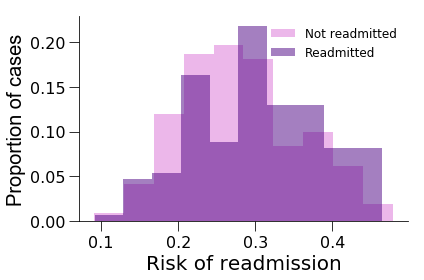

In [6]:
# Let's evaluate our model
from sklearn.metrics import confusion_matrix
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
rcParams.update({'figure.autolayout': True})
curr_dir = os.getcwd()
figFolder=os.path.join(curr_dir,'Figures')

cmap = cm.get_cmap('Purples')
cmap2=cm.get_cmap('Spectral')

X_xtestNew=X_xtest.loc[:,['grouped_age_[60-100)','change_No',\
                          'primary_diagnosis_neoplasm',\
                          'num_lab_procedures','number_emergency']]
X_xtestNew=add_constant(X_xtestNew)
y_predNew=reducedmodel.predict(X_xtestNew)

# Plot how well the model fit


# # Ok, let's plot the predicted risk of early readmission for the two groups
# i.e. patients that were not readmitted and those that were

readmitted_risk=y_predNew[y_xtest==True]
notreadmitted_risk=y_predNew[y_xtest==False]

#x = [21,22,23,4,5,6,77,8,9,10,31,32,33,34,35,36,37,18,49,50,100]
#num_bins = 5
plt.figure()
ax=plt.subplot()
weights=np.ones_like(notreadmitted_risk)/np.sum(y_xtest==False)
nNotReadmitted, binsNotReadmitted, patchesNotReadmitted = plt.hist(notreadmitted_risk, 10,weights=weights,facecolor='orchid', alpha=0.5)

weights=np.ones_like(readmitted_risk)/np.sum(y_xtest==True)
nReadmitted, binsReadmitted, patchesReadmitted = plt.hist(readmitted_risk, 10, weights=weights,facecolor='indigo', alpha=0.5)
figfont={'fontname':'Arial'}
plt.ylabel('Proportion of cases',fontsize=20,**figfont)
plt.xlabel('Risk of readmission',fontsize=20)
# #plt.axis('square')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.legend(['Not readmitted','Readmitted'],frameon=False,fontsize=12)
plt.tick_params(labelsize=16,length=10)


# Save the current figure
thisFig='ReadmissionRisk.pdf'
figname=os.path.join(figFolder,thisFig)
plt.savefig(figname,transparent=True,pad_inches=1)
plt.show()

# plt.grid(True)
# plt.show()


/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


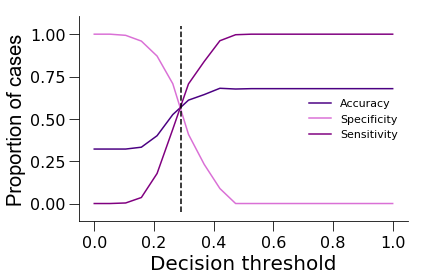


Using decision threshold=0.3
Accuracy: 0.5886
Sensitivity: 0.5102
Specificity: 0.6258


In [10]:
# Now, plot accuracy, sensitivity, specificity as a function of decision threshold

decisionthresh_bins=np.linspace(0,1,20)
accuracy_bins=np.zeros_like(decisionthresh_bins)
specificity_bins=np.zeros_like(decisionthresh_bins)
sensitivity_bins=np.zeros_like(decisionthresh_bins)

# Now, move the decision threshold and see how these variables change

for ii,thresh in enumerate(decisionthresh_bins):
    yclass=y_predNew>thresh
    # Measure accuracy
    tempval=sum(yclass==y_xtest)/len(y_xtest)
    accuracy_bins[ii]=tempval
    # Measure sensitivity
    tempval=sum(yclass[y_xtest==True]==y_xtest[y_xtest==True])/sum(y_xtest==True)
    sensitivity_bins[ii]=tempval
    # Measure specificity
    tempval=sum(yclass[y_xtest==False]==y_xtest[y_xtest==False])/sum(y_xtest==False)
    specificity_bins[ii]=tempval


# Now plot how these measure varies with decision threshold

plt.figure()
ax=plt.subplot()
plt.plot(decisionthresh_bins,accuracy_bins,color='indigo')
plt.plot(decisionthresh_bins,sensitivity_bins,color='orchid')
plt.plot(decisionthresh_bins,specificity_bins,color='purple')
ylim=plt.ylim()
plt.plot([0.29,0.29],ylim,'--k')
figfont={'fontname':'Arial'}
plt.ylabel('Proportion of cases',fontsize=20,**figfont)
plt.xlabel('Decision threshold',fontsize=20)
# #plt.axis('square')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.legend(['Accuracy','Specificity','Sensitivity'],fontsize=11,frameon=False)
plt.tick_params(labelsize=16,length=10)
plt.tight_layout
# Save the current figure
thisFig='decisionthreshold.pdf'
figname=os.path.join(figFolder,thisFig)
plt.savefig(figname,transparent=True,pad_inches=1)
plt.show()


# Print the accuracy, sensitivity and specificity at the chosen threshold=0.3
yclass=y_predNew>0.3
# Measure accuracy
accuracy=sum(yclass==y_xtest)/len(y_xtest)
# Measure sensitivity
sensitivity=sum(yclass[y_xtest==True]==y_xtest[y_xtest==True])/sum(y_xtest==True)
# Measure specificity
specificity=sum(yclass[y_xtest==False]==y_xtest[y_xtest==False])/sum(y_xtest==False)
print('\nUsing decision threshold=0.3')
print('Accuracy: %.4f' %accuracy)
print('Sensitivity: %.4f' %sensitivity)
print('Specificity: %.4f' %specificity)

In [8]:
# Now, print out the biggest contributors
model_coefs=(reducedmodel.params)
model_coefs

const                        -1.320538
grouped_age_[60-100)          0.488926
change_No                    -0.381129
primary_diagnosis_neoplasm   -0.607163
num_lab_procedures            0.008944
number_emergency              0.296775
dtype: float64

In [9]:
# Hmmm..ok, so reduced model seems to be the best thing we can do